# <center>Livrable Projet DATA SCIENCE</center>

### Contexte

L'entreprise TouNum est une entreprise de numérisation de documents. Elle prospose différents services dont la numérisation de base de document papier pour les entreprises clientes. TouNum veut optimiser et rendre intelligent ce processus de scanning en incluant des outils de Machine Learning. Le gain de temps serait phénoménale aux vues des nombreuses données que l'entreprise doit scanner.
Pour cela, TouNum fait appel à CESI pour réaliser cette prestation.

### Objectif

L'objectif est que l'équipe de data scientist de CESI réalise cette solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique. Il faudra également améliorer la qualité des images scannées ayant des qualités variables (parfois floues, ou bruitées).

<img src="imageSrc/caption image.PNG"/>

### Enjeux

TouNum va pouvoir réduire au maximum le temps de scan et automatiser la reconnaissance des documents scannés. Elle va donc pouvoir réaliser plus de contrats et augmenter la satisfaction client.

### Contraintes techniques

L'implémentation des algorithmes doit être réaliser sur Python, notamment les librairies Scikit et TensorFlow. La librairie Pandas doit être utilisé pour manipuler le dataset et ImageIO pour le charger. NumPy et MatPlotLib seront nécessaire pour le calcul scientifique et la modélisation.

Le programme à livrer devra respecter le workflow suivant :

<img src="imageSrc/workflow.PNG"/>

#### Classification:

La classification d'image se fera à l'aide de réseaux de neurones. Cette dernière doit distinguer les photos d'un autre documents, tel que schémas, textes scannés, voir peintures.
TouNoum possède un dataset rempli d'images divers pour entrainer le réseau de neurones.

#### Prétraitement

Le prétraitement dois utiliser des filtres convolutifs afin d'améliorer la qualité. Il doit établir un compromis entre débruitage et affutage.

#### Captionning

Le Captionning devra légender automatiquement les images. Il utilisera deux techniques de Machine Learning : les réseaux de neurones convolutifs (CNN) pour prétraiter l'image en identifiant les zones d’intérêt, et les réseaux de neurones récurrents (RNN) pour générer les étiquettes. Il faudra être vigilant quant aux ressources RAM. Un dataset d'étiquetage classique est disponible pour l’apprentissage supervisé.

### Livrable

La solution doit sous forme de notebook Jupiter entièrement automatisé. Il doit être conçu pour être faciliter mis en production et maintenance.
Il faut démontrer la pertinence du modèle de manière rigoureuse et pédagogique.

#### Jalons

CESI devra dois rendre le prototype complet et fonctionnel du programme pour le 23 janvier. 
TouNum exige également 3 dates de rendu pour suivre la bonne avancé du projet.
<ul>
    <li>18/12/20 : Prétraitement d'image</li>
    <li>15/01/21 : Classification binaire</li>
    <li>20/01/21 : Captioning d'images</li>
    <li>22/01/21 : Démonstration </li>
</ul>


## Livrable 1 - Prétraitement (denoising/sharpening…)

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Il y a deux traitements à réaliser : le débruitage, et l’affutage. Vous devrez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s’appuieront sur des notions assez simples autour des filtres de convolution, et les appliqueront pour améliorer la qualité de l’image. Il faudra notamment décider d’un compromis entre dé-bruitage et affutage.

Le notebook devra intégrer :
<ul>
    <li>Le code de chargement du fichier.</li>
    <li>Le code du débruitage sur un sous-ensemble d’images bruitées. Le code doit être accompagné d’explications.</li>
    <li>Le code de l’affutage sur un sous-ensembles d’images floutées. Le code doit être accompagné d’explications.</li>
    <li>
        Une étude de cas explicitant les compromis entre ces deux opérations. Cette partie du livrable doit inclure le bruitage d’images et montrer la perte de détails, ou l’affutage d’images et montrer l’apparition du bruit.
    </li>
</ul>

<b>Ce livrable est à fournir pour le 18/12/2020</b>

#### Importation des librairies utilisées

In [49]:
!pip3 install opencv-python

In [50]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2
import threading
from queue import Queue
from multiprocessing import Pool
import time
import numpy as np
import pandas as pd

#### Méthodes de chargement des images

In [51]:
def get_image(path, filename):
    return io.imread(path + filename)

def save_image(path, filename, content):
    #Check if folder exists
    if not os.path.isdir(path):
        os.makedirs(path)
    imageio.imwrite(path + filename , content)
    
def get_file_amount(path):
    return len(os.listdir(path))

def get_metric_stat(pre_data, post_data):
    data = [
        np.array([min(pre_data), max(pre_data), np.median(pre_data), np.average(pre_data)]),
        np.array([min(post_data), max(post_data), np.median(post_data), np.average(post_data)])
    ]

    data_array = pd.DataFrame(data,
                              index = ["pre_processed", "post_processed"],
                              columns = ["Min value", "Max value", "Median value", "Average value"])
    print(data_array)


 #### Méthode d'affichage des images

In [52]:
def display_images(index_img, image):
    ax = axs[index_img//10, index_img%10]
    ax.axis('off')
    ax.set_title("Image n° "+ str(index_img+1))
    ax.imshow(image)

## Défloutage de l'image

Pour le défloutage des images, on utilise un filtre Laplacien. Ce filtre nous permet d'affuter les images grâce à une fonction de convolution de la librairie opencv sur l'image récupérée.

La variante de filtre choisie nous permet sur le jeu de données fourni d'affuter les images suffisemment pour retirer le flou présent sans pour autant y ajouter de bruit.

In [47]:
# Deblurring function
def remove_blur(img):
    # Creation of a Laplacian kernel to use for debluring
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    
    # Convolution of the kernel with the image given in the function's parameter
    return cv2.filter2D(img, -1, kernel)

def get_blurry_indicator(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return fm

In [48]:
# Create the list of file to treat
folder = "./Dataset/Blurry/"
listing = os.listdir(folder)

In [58]:
# Thread execution
def process_fpath(name):
    path = folder+name
    img = get_image(folder,name)

     # Get initial Blur metric
    original_blur_metric = get_blurry_indicator(img)
    pre_processed_data.append(original_blur_metric)
    
    # Remove blur from the colored image image
    deblurred_img = remove_blur(img)

    # Get initial Blur metric
    processed_blur_metric = get_blurry_indicator(deblurred_img)
    post_processed_data.append(processed_blur_metric)
    
    #print("image " + name + " - initial : " + str(original_blur_metric)
     #   + " - processed : " + str(processed_blur_metric)
     #   + " - difference : " + str(processed_blur_metric - original_blur_metric)+"\n")
    
    # Saving Image
    save_image("./Dataset/processed/deblurred/", name, deblurred_img)

# Loop on the list of file

threads = []

pre_processed_data = []
post_processed_data = []

if __name__ == '__main__':
    for name in listing:
        #process_fpath(name)
        t = threading.Thread(target=process_fpath, args=(name,))
        threads.append(t)
        
    # Start them all
    for thread in threads:
        thread.start()

    # Wait for all to complete
    for thread in threads:
        thread.join()
    
    get_metric_stat(pre_processed_data, post_processed_data)
    

                 Min value     Max value  Median value  Average value
pre_processed     7.213613   1283.340108    142.703144     196.803279
post_processed  429.898374  33922.544000   4806.075382    6132.553243


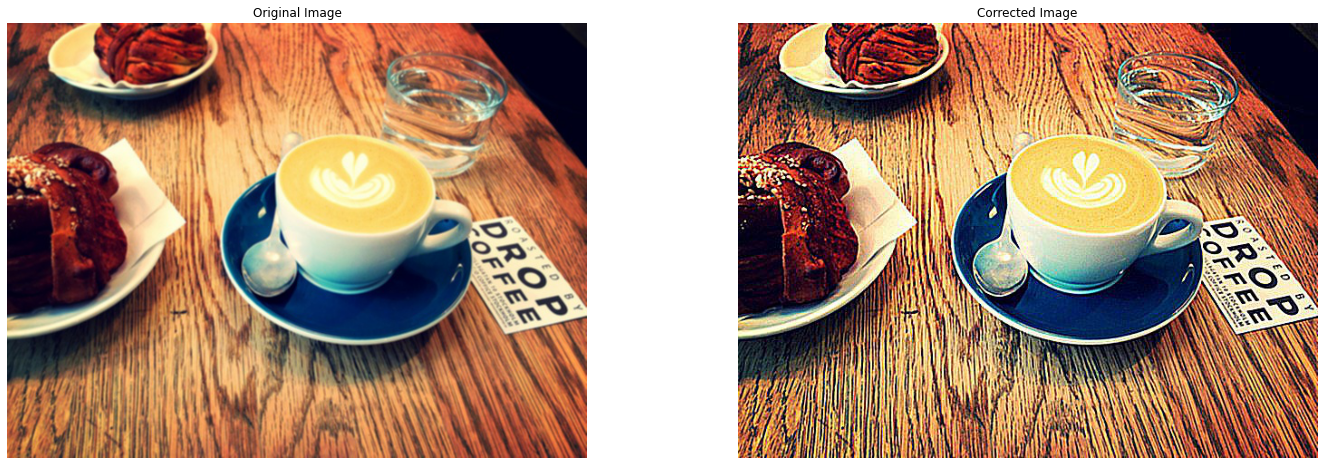

In [81]:
import random

plt.figure(figsize=(24, 8))

def display_image_diff(originalPath, diffPath, filename=None):
    if not filename:
        # Get a random file from directory
        filename = random.choice(os.listdir(originalPath)) 
    
    plt.subplot(121)
    plt.imshow(get_image(originalPath, filename))
    plt.axis('off')
    plt.title("Original Image")
    
    # Corrected Image noise
    plt.subplot(122)
    plt.imshow(get_image(diffPath, filename))
    plt.axis('off')
    plt.title("Corrected Image")
    
# Filename MUST be the same for both directories    
display_image_diff("./Dataset/Blurry/", "./Dataset/processed/deblurred/")

# Débruitage
La capture d'un signal lumineux par un appareil photographique s'accompagne le plus souvent d'informations non désirées : le « bruit ». L'essentiel de ce « bruit » (des pixels trop clairs ou trop sombre en trop grand nombre ou de manière irrégulière, par exemple) est dû au capteur.

### Le débruitage par morceaux (par patchs)
Le débruitage par morceaux est une technique de débruitage d'image utilisant l'algorithme de réduction du bruit numérique appelé en Anglais "non-local means".

La méthode repose sur un principe simple, remplacer la couleur d'un pixel par une moyenne des couleurs de pixels similaires. Mais les pixels les plus similaires à un pixel donné n'ont aucune raison d'être proches. Il est donc nécessaire de scanner une vaste partie de l'image à la recherche de tous les pixels qui ressemblent vraiment au pixel que l'on veut débruiter.

### Pourquoi cette methode ?
Le résultat d'un tel filtrage permet d’amoindrir la perte de détails au sein de l'image, comparé aux filtres réalisant des moyennes localement tel que le filtre de Gauss ou le filtre de Wiener, le bruit généré par l'algorithme "non-local means" est plus proche du bruit blanc.

**Syntax:**
cv2.fastNlMeansDenoisingColored( P1, P2, float P3, float P4, int P5, int P6)

**Parameters:**
* P1 – Source Image Array
* P2 – Destination Image Array
* P3 – Size in pixels of the template patch that is used to compute weights.
* P4 – Size in pixels of the window that is used to compute a weighted average for the given pixel.
* P5 – Parameter regulating filter strength for luminance component.
* P6 – Same as above but for color components // Not used in a grayscale image.


In [64]:
# Remove Noise function
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image,None,10,10,7,15)

In [65]:
# Prend les nom de tout les fichier dans un dossier donner
folder = "./Dataset/Noisy/"
listing = os.listdir(folder)

In [71]:
# Thread execution
def process_fpath(name):
    print(name)
    path = folder+name
    img = get_image(folder,name)
    denoised_img = remove_noise(img)
    save_image("./Dataset/processed/denoised/", name, denoised_img)

#boucle sur la liste de fichier

pre_processed_data = []
post_processed_data = []

threads = []
if __name__ == '__main__':
    for name in listing:
        #process_fpath(name)
        t = threading.Thread(target=process_fpath, args=(name,))
        threads.append(t)
        
    # Start them all
    for thread in threads:
        thread.start()

    # Wait for all to complete
    for thread in threads:
        thread.join()
    
    get_metric_stat(pre_processed_data, post_processed_data)

noisy_001.jpg
noisy_002.jpg
noisy_003.jpg
noisy_004.jpg
noisy_005.jpg
noisy_006.jpg
noisy_007.jpg
noisy_008.jpg
noisy_009.jpg
noisy_010.jpg
noisy_011.jpg
noisy_012.jpg
noisy_013.jpg
noisy_014.jpg
noisy_015.jpg
noisy_016.jpg
noisy_017.jpg
noisy_018.jpg
noisy_019.jpg
noisy_020.jpg
noisy_021.jpg
noisy_022.jpg
noisy_023.jpg
noisy_024.jpg
noisy_025.jpg
noisy_026.jpg
noisy_027.jpg
noisy_028.jpg
noisy_029.jpg
noisy_030.jpg
noisy_031.jpg
noisy_032.jpg
noisy_033.jpg
noisy_034.jpg
noisy_035.jpg
noisy_036.jpg
noisy_037.jpg
noisy_038.jpg
noisy_039.jpg
noisy_040.jpg
noisy_041.jpg
noisy_042.jpg
noisy_043.jpg
noisy_044.jpg
noisy_045.jpg
noisy_046.jpg
noisy_047.jpg
noisy_048.jpg
noisy_049.jpg
noisy_050.jpg
noisy_051.jpg
noisy_052.jpg
noisy_053.jpg
noisy_054.jpg
noisy_055.jpg
noisy_056.jpg
noisy_057.jpg
noisy_058.jpg
noisy_059.jpg
noisy_060.jpg
noisy_061.jpg
noisy_062.jpg
noisy_063.jpg
noisy_064.jpg
noisy_065.jpg
noisy_066.jpg
noisy_067.jpg
noisy_068.jpg
noisy_069.jpg
noisy_070.jpg
noisy_071.jpg
noisy_

# Sources

## Image


## Défloutage


## Debruitage
* https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
* http://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf
